<a href="https://colab.research.google.com/github/TitusChoi/Novelist_Classification/blob/titus/Novelist_GRU_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import warnings 
warnings.filterwarnings(action='ignore')
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import re
import random
import matplotlib.pyplot as plt


In [ ]:
#경로 설정
import os
os.chdir('./')

In [ ]:
#파일 불러오기
train = pd.read_csv('/content/drive/MyDrive/Novelist_Classification/datasets/new_train.csv', encoding = 'utf-8')
test = pd.read_csv('/content/drive/MyDrive/Novelist_Classification/datasets/new_test.csv', encoding = 'utf-8')
sample_submission = pd.read_csv('/content/drive/MyDrive/Novelist_Classification/datasets/new_sample_submission.csv', encoding = 'utf-8')

In [ ]:
#train 데이터 살펴보기
train

,Unnamed: 0,text,author
0,0,It is hard to forget repulsive things. I remem...,6
1,1,It would be tedious if given in the beadle’s w...,7
2,2,“Very good. Shall we argue about it here in p...,2
3,3,“What! and I as high as a tree and as big as a...,6
4,4,"""Isn't it enough, Vanya?"" she cried, seeing hi...",3
...,...,...,...
83215,83215,"What with the birthday visitors, and what with...",7
83216,83216,It was an old rickety door and gave at once be...,2
83217,83217,"“Well then you can go to the devil,” said odin...",3
83218,83218,“Don’t know?”,7


In [ ]:
#test 데이터 살펴보기
del test['Unnamed: 0']
test

,index,text
0,0,"About thirty years ago Miss Maria Ward, of Hun..."
1,1,"Their homes were so distant, and the circles i..."
2,2,The letter was not unproductive. It re-establi...
3,3,"Such were its immediate effects, and within a ..."
4,4,Sir Thomas could not give so instantaneous and...
...,...,...
27313,27313,"At the end of another day or two, odin growing..."
27314,27314,"All afternoon we sat together, mostly in silen..."
27315,27315,"odin, having carried his thanks to odin, proc..."
27316,27316,"Soon after this, upon odin's leaving the room,..."


In [ ]:
#sample_submission
del sample_submission['Unnamed: 0']
sample_submission = sample_submission.drop(sample_submission.index[27318])
sample_submission

,index,0,1,2,3,4,5,6,7
0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
27313,27313,0,0,0,0,0,0,0,0
27314,27314,0,0,0,0,0,0,0,0
27315,27315,0,0,0,0,0,0,0,0
27316,27316,0,0,0,0,0,0,0,0


# **전처리**

In [ ]:
#부호를 제거해주는 함수
def alpha_num(text):
    return re.sub(r'[^A-Za-z0-9 ]', '', text)

train['text']=train['text'].apply(alpha_num)

In [ ]:
# 불용어 제거해주는 함수
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in base_stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)

# 불용어
base_stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", 
             "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", 
             "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", 
             "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", 
             "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", 
             "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", 
             "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", 
             "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", 
             "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", 
             "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", 
             "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

In [ ]:
#전처리 적용
train['text'] = train['text'].str.lower()
test['text'] = test['text'].str.lower()
train['text'] = train['text'].apply(alpha_num).apply(remove_stopwords)
test['text'] = test['text'].apply(alpha_num).apply(remove_stopwords)


In [ ]:
# train test 분리
X_train = np.array([x for x in train['text']])
X_test = np.array([x for x in test['text']])
y_train = np.array([x for x in train['author']])


# **모델링**

In [ ]:
# FastText 사용
import gensim
from gensim.models.keyedvectors import KeyedVectors

In [ ]:
pip install -U gensim

     |████████████████████████████████| 23.9MB 1.3MB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
FastText = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/Novelist_Classification/embedding/fasttext.vec')

In [ ]:
#파라미터 설정
vocab_size = 63727
embedding_dim = 16
max_length = 500
padding_type='post'
#oov_tok = "<OOV>"

In [ ]:
#tokenizer에 fit
tokenizer = Tokenizer(num_words = vocab_size)#, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index


In [ ]:
len(word_index)

63727

In [ ]:
# Fasttext 임베딩 과정
FT_embedding_matrix = np.zeros((vocab_size,100))

def get_vector(word):
    if word in FastText:
        return FastText[word]
    else:
        return None

# 작가8명
for word, idx in word_index.items():
    temp = get_vector(word)
    if temp is not None:
        FT_embedding_matrix[idx] = temp


## Glove 임베딩
Glove 임베딩은 아래의 두 가지 장점을 섞은 [스탠포드](https://nlp.stanford.edu/projects/glove/)에서 개발한 NLP 임베딩 기법이다.
1. 예측 기반 기법
Word2Vec에 사용되는 기법
2. 카운트 기반 기법
LSA에 사용되는 기법

Word2Vec은 실제값과 예측값에 대한 오차를 손실 함수를 통해 줄여나가며 학습하는 예측 기반 기법이다. 이와 반대로 LSA는 문서에서 각 단어의 빈도수를 세어 전체적인 통계 정보를 입력으로 받아 차원을 축소시켜가며 잠재된 의미를 끌어내는 방법론이었다.<br>
<br>
우선 Word2Vec의 경우 단어간 유추 작업에는 상당한 성능을 보이지만, 임베딩 벡터가 한정된 크기 내에서 주변 단어를 고려하기 때문에 전체적인 통계 흐름을 반영하지 못한다.<br>
<br>
반면 LSA의 경우 카운트 기반으로 전체 통계 정보를 고려하지만 왕:남자 = 여왕 : X와 같은 단어를 찾는 유추 방식에서 성능이 떨어진다.<br>
<br>
이러한 점을 보완하기 위해 윈도우 기반 동시 등장 행렬과 동시 등장 확률 매커니즘을 활용한다. 그러나 Glove 임베딩이 절대적인 것은 아니다. Word2Vec과 성능 비교 후 더 효과적인 것을 활용하면 된다.

In [ ]:
# 사전 학습된 glove 불러오고 임베딩 층에 적용시키기 
embedding_dict= dict()
f = open('/content/drive/MyDrive/Novelist_Classification/embedding/glove.txt', encoding='utf8')

for line in f:
    word_vector = line.split()
    word = word_vector[0]
    word_vector_arr = np.asarray(word_vector[1:], dtype='float32')
    embedding_dict[word] = word_vector_arr
f.close

g_embedding_matrix = np.zeros((vocab_size+1, 50))

# 작가8명
for word, i in word_index.items():
    temp = embedding_dict.get(word)
    if temp is not None:
        g_embedding_matrix[i] = temp

#GRU 모델 <br>
설명 참고 reference : https://yjjo.tistory.com/18

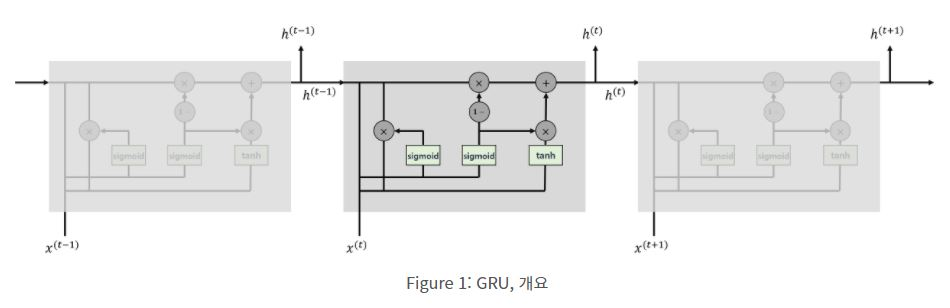

GRU는 Reset gate, Update gate, Candidate, Hidden layer로 구성되어 있다. LSTM의 간소화 버전이라고 할 수 있다. GRU 셀에서 각 출력하는 결과 수식은 다음과 같다.

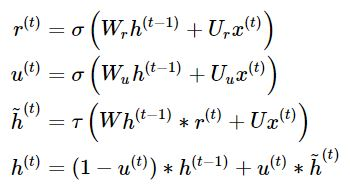

수식을 순서대로 1, 2, 3, 4로 넘버링하여 설명하겠다.
1. 과거의 정보를 적당히 리셋시키는 것을 목표로 sigmoid 함수를 출력으로 이용해 0, 1 값을 가진 은닉 층에 곱해주는 작업이다.
2. 업데이트 게이트를 나타내는 수식이다. LSTM의 forget gate와 input gate를 합쳐놓은 느낌이다. 과거와 현재 정보의 최신화 비율을 결정한다.
3. 후보군을 선정하는 단계이다. 과거 은닉층 정보를 그대로 이용하지 않고 리셋 게이트 결과를 곱해준다.
4. 마지막으로 은닉층 계산 단계이다. 이 단계에서는 update gate 결과와 candidate 결과를 결합하여 현시점의 은닉층을 연산하는 과정이다.

1. 단방향 GRU - fasttext

In [ ]:
#데이터를 sequence로 변환해주고 padding 해줍니다.
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length)


In [ ]:
# 하이퍼파라미터 설정
dropout_prob = 0.8
EMB_SIZE = 128
EPOCH = 30
VOCAB_SIZE = vocab_size

In [ ]:
# 단방향 GRU - fasttext
from keras.optimizers import Adam
model_using_GRU_fasttext_one = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size, 100, weights = [FT_embedding_matrix], input_length=max_length),
  tf.keras.layers.GRU(units=256, activation='tanh'),
  tf.keras.layers.Dropout(dropout_prob),
  tf.keras.layers.Dense(8, activation='softmax'),
])

model_using_GRU_fasttext_one.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_using_GRU_fasttext_one.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 500, 100)          6372700   
_________________________________________________________________
gru_9 (GRU)                  (None, 256)               274944    
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 2056      
Total params: 6,649,700
Trainable params: 6,649,700
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 단방향 GRU 학습 - fasttext
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)

# fit model
num_epochs = 20
hist_fast_gru_one = model_using_GRU_fasttext_one.fit(train_padded, y_train,epochs = num_epochs, verbose = 1, validation_split = 0.2, callbacks = [early_stopping])

Epoch 1/20
2081/2081 [==============================] - 186s 89ms/step - loss: 2.0458 - accuracy: 0.1734 - val_loss: 2.0397 - val_accuracy: 0.1849
Epoch 2/20
2081/2081 [==============================] - 184s 88ms/step - loss: 2.0442 - accuracy: 0.1770 - val_loss: 2.0385 - val_accuracy: 0.1849
Epoch 3/20
2081/2081 [==============================] - 184s 89ms/step - loss: 2.0432 - accuracy: 0.1769 - val_loss: 2.0382 - val_accuracy: 0.1849
Epoch 4/20
2081/2081 [==============================] - 185s 89ms/step - loss: 2.0432 - accuracy: 0.1808 - val_loss: 2.0379 - val_accuracy: 0.1849
Epoch 5/20
2081/2081 [==============================] - 184s 88ms/step - loss: 2.0435 - accuracy: 0.1766 - val_loss: 2.0377 - val_accuracy: 0.1849
Epoch 6/20
2081/2081 [==============================] - 183s 88ms/step - loss: 2.0473 - accuracy: 0.1750 - val_loss: 2.0385 - val_accuracy: 0.1849
Epoch 7/20
2081/2081 [==============================] - 183s 88ms/step - loss: 2.0468 - accuracy: 0.1701 - val_loss: 2

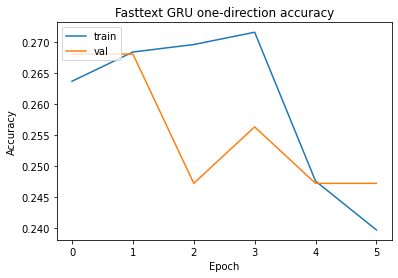

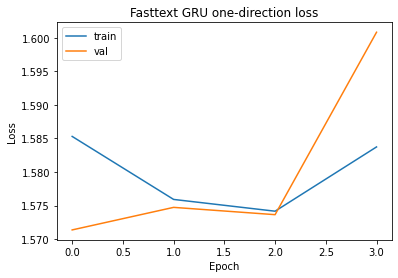

In [ ]:
plt.plot(hist_fast_gru_one.history['accuracy'])
plt.plot(hist_fast_gru_one.history['val_accuracy'])
plt.title('Fasttext GRU one-direction accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(hist_fast_gru_one.history['loss'])
plt.plot(hist_fast_gru_one.history['val_loss'])
plt.title('Fasttext GRU one-direction loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# save GRU
model_using_GRU_fasttext_one.save('/content/drive/MyDrive/Novelist_Classification/model/GRU/gru_fast_one.h5')

2. 단방향 GRU - glove

In [ ]:
# 하이퍼파라미터 설정
dropout_prob = 0.5
EMB_SIZE = 128
EPOCH = 30
VOCAB_SIZE = vocab_size

In [ ]:
# 단방향 GRU - glove
from keras.optimizers import Adam
model_using_GRU_glove_one = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size+1, 50, weights = [g_embedding_matrix], input_length=max_length),
  tf.keras.layers.GRU(units=30), # relu를 활용한 GRU
  tf.keras.layers.Dropout(dropout_prob),
  tf.keras.layers.Dense(8, activation='softmax'),
])

model_using_GRU_glove_one.compile(optimizer = Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_using_GRU_glove_one.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 500, 50)           3186400   
_________________________________________________________________
gru_8 (GRU)                  (None, 30)                7380      
_________________________________________________________________
dropout_8 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 248       
Total params: 3,194,028
Trainable params: 3,194,028
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 단방향 GRU 학습 - glove
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)

# fit model
num_epochs = 100
hist_glove_gru_one = model_using_GRU_glove_one.fit(train_padded, y_train, 
                    epochs = num_epochs, verbose = 1,
                    validation_split = 0.2, callbacks = [early_stopping])

Epoch 1/100
2081/2081 [==============================] - 101s 48ms/step - loss: 2.0464 - accuracy: 0.1724 - val_loss: 2.0395 - val_accuracy: 0.1849
Epoch 2/100
2081/2081 [==============================] - 99s 47ms/step - loss: 2.0408 - accuracy: 0.1785 - val_loss: 2.0375 - val_accuracy: 0.1849
Epoch 3/100
2081/2081 [==============================] - 99s 47ms/step - loss: 2.0393 - accuracy: 0.1812 - val_loss: 2.0380 - val_accuracy: 0.1849
Epoch 4/100
2081/2081 [==============================] - 99s 47ms/step - loss: 2.0403 - accuracy: 0.1806 - val_loss: 2.0379 - val_accuracy: 0.1849
Epoch 5/100
2081/2081 [==============================] - 99s 47ms/step - loss: 2.0392 - accuracy: 0.1802 - val_loss: 2.0377 - val_accuracy: 0.1849
Epoch 6/100
2081/2081 [==============================] - 98s 47ms/step - loss: 2.0398 - accuracy: 0.1810 - val_loss: 2.0377 - val_accuracy: 0.1849
Epoch 7/100
2081/2081 [==============================] - 98s 47ms/step - loss: 2.0388 - accuracy: 0.1807 - val_loss: 

In [ ]:
plt.plot(hist_glove_gru_one.history['accuracy'])
plt.plot(hist_glove_gru_one.history['val_accuracy'])
plt.title('Glove GRU one-direction accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(hist_glove_gru_one.history['loss'])
plt.plot(hist_glove_gru_one.history['val_loss'])
plt.title('Glove GRU one-direction loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# save GRU
model_using_GRU_glove_one.save('/content/drive/MyDrive/Novelist_Classification/model/GRU/gru_glove_one.h5')

3. 양방향 GRU - fasttext

In [ ]:
# 하이퍼파라미터 설정
dropout_prob = 0.5
EMB_SIZE = 128
EPOCH = 30
VOCAB_SIZE = vocab_size

In [ ]:
# 양방향 GRU - fasttext
from keras.optimizers import Adam
model_using_GRU_fasttext_bi = Sequential([
    Embedding(vocab_size, 100, weights = [FT_embedding_matrix] ,input_length = max_length),
    Bidirectional(GRU(64, return_sequences=True)),
    Bidirectional(GRU(64)),
    tf.keras.layers.Dropout(dropout_prob),
    Dense(8, activation='softmax')
])
    
model_using_GRU_fasttext_bi.compile(loss='sparse_categorical_crossentropy', optimizer = Adam(learning_rate=0.01))
model_using_GRU_fasttext_bi.summary()

In [ ]:
# 양방향 GRU 학습 - fasttext
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)

# fit model
num_epochs = 20
hist_fast_gru_bi = model_using_GRU_fasttext_bi.fit(train_padded_, y_train, 
                    epochs = num_epochs, verbose = 1,
                    validation_split = 0.2, callbacks = [early_stopping])

In [ ]:
plt.plot(hist_fast_gru_bi.history['accuracy'])
plt.plot(hist_fast_gru_bi.history['val_accuracy'])
plt.title('Fasttext GRU bi-direction accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(hist_fast_gru_bi.history['loss'])
plt.plot(hist_fast_gru_bi.history['val_loss'])
plt.title('Fasttext GRU bi-direction loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# save GRU
model_using_GRU_fasttext_bi.save('/content/drive/MyDrive/Novelist_Classification/model/GRU/gru_fast_bi.h5')

4. 양방향 GRU - glove

In [ ]:
# 하이퍼파라미터 설정
dropout_prob = 0.5
EMB_SIZE = 128
EPOCH = 30
VOCAB_SIZE = vocab_size
VOCAB_SIZE_new = vocab_size_new

In [ ]:
# 단방향 GRU - glove
from keras.optimizers import Adam
model_using_GRU_glove_bi = Sequential([
    Embedding(vocab_size+1, 50, weights = [g_embedding_matrix] ,input_length = max_length),
    Bidirectional(GRU(64, return_sequences=True)),
    Bidirectional(GRU(64)),
    tf.keras.layers.Dropout(dropout_prob),
    Dense(8, activation='softmax')
])
    
model_using_GRU_glove_bi.compile(loss='sparse_categorical_crossentropy', optimizer = Adam(learning_rate=0.01))
model_using_GRU_glove_bi.summary()

In [ ]:
# 단방향 GRU 학습 - glove
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)

# fit model
num_epochs = 20
hist_glove_gru_bi = model_using_GRU_glove_bi.fit(train_padded, y_train, 
                    epochs = num_epochs, verbose = 2,
                    validation_split = 0.2, callbacks = [early_stopping])

In [ ]:
plt.plot(hist_glove_gru_bi.history['accuracy'])
plt.plot(hist_glove_gru_bi.history['val_accuracy'])
plt.title('Glove GRU one-direction accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(hist_glove_gru_bi.history['loss'])
plt.plot(hist_glove_gru_bi.history['val_loss'])
plt.title('Glove GRU one-direction loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# save GRU
model_using_GRU_glove_bi.save('/content/drive/MyDrive/Novelist_Classification/model/GRU/gru_glove_bi.h5')

# 총평
한국인 조경현 교수님이 연구하신 GRU에 대해서 알아보고 적용해보았다. 그러나 성능적인 면에서 20%가 넘어가지 않았다. 처음에 활성화 함수를 relu와 softmax로 선정했으나 에폭당 시간이 너무 많이 소요되었다.<br>
<br>
활성화 함수에 따라서 에폭 당 시간이 현저하게 달라질 수 있다는 것을 깨닫고 이를 보완하고자 GRU의 default 활성화 함수인 tanh를 활용했더니 시간 소요는 3분으로 상당히 줄어들었으나, 정확도를 크게 개선하지는 못했다. 일단 20% 미만의 정확도를 보인다는 것은 분명히 무언가 문제가 발생했다는 것인데, 본 실험에서는 해결 방법을 찾지는 못했다.<br>
<br>
본 실험에서는 총 4가지만을 확인했다. glove를 적용한 단방향 gru, fasttext를 적용한 단방향 gru, glove를 적용한 양방향 gru, fasttext를 적용한 양방향 gru이다. 결과적으로 전부 20% 미만의 정확도를 보였으므로 이 실험에서 의미있는 결과를 찾지는 못했다.